In [ ]:
!pip install numpy
!pip install requests
!pip install json
!pip install traceback
!pip install unicodedata
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [1]:
import requests
import json
import traceback
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import svm
from sklearn.model_selection import train_test_split

# Data Collection

Used IMDB dataset and alternative data for the purpose of this task. The data for this project is obtained from:

* IMDb's datasets: https://www.imdb.com/interfaces/
* RapidAPI's Movie Database (IMDB Alternative): https://rapidapi.com/rapidapi/api/movie-database-imdb-alternative
* TMDb's (The Movie Database) API: https://developers.themoviedb.org/3/getting-started/introduction



In [2]:
name_df = pd.read_csv('name.basics.tsv', sep='\t')
titles_akas_df = pd.read_csv('title.akas.tsv', sep='\t')
titles_basics_df = pd.read_csv('title.basics.tsv', sep='\t')
titles_crew_df = pd.read_csv('title.crew.tsv', sep='\t')
titles_episode_df = pd.read_csv('title.episode.tsv', sep='\t')
titles_principals_df = pd.read_csv('title.principals.tsv', sep='\t')
titles_ratings_df = pd.read_csv('title.ratings.tsv', sep='\t')

/home/kbichave/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/kbichave/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Above files are provided in the IMDb dataset. Used these files to get initial understanding of the data and the information possesed in each of these files. For the sake of demonstration and limited free tier available for RapidAPI, the data has been limited to be the movies released between 1990 and 2010. 

Used following features from these files:
* Regions
* IMDb ratings (called averageRating)
* Directors and Writers
* Runtimes

In [3]:
# title_IDs = list(set(titles_akas_df['titleId']))\

titles_basics_df = titles_basics_df.apply(lambda x: x.replace('\\N', np.nan))
titles_basics_df = titles_basics_df[titles_basics_df['runtimeMinutes'].notna()]
titles_basics_df = titles_basics_df[titles_basics_df['startYear'].notna()]
title_IDs_akas = set(titles_akas_df[titles_akas_df['region']=='US']['titleId'].tolist())
title_IDs_basics = titles_basics_df[titles_basics_df['titleType']=='movie']
title_IDs_basics = title_IDs_basics[titles_basics_df['startYear'].astype(int).between(1990, 2020, inclusive=True)]['tconst'].tolist()
title_IDs = list(title_IDs_akas.intersection(title_IDs_basics))

/home/kbichave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Filtered data to get the titleIDs for movies released between 1990 and 2020. The dataset otherwise contains a large variety of other media types like TV shows, video games and so on. Replaced next line character with NaNs and only selected the IDs where the rows dont contain NaNs for features that would be important for prediction

In [5]:
def remove_control_characters(s):
    return "".join(ch for ch in s if unicodedata.category(ch)[0]!="C" and ch!='\\')

url = "https://movie-database-imdb-alternative.p.rapidapi.com/"

headers = {
    'x-rapidapi-key': '', #replace key here
    'x-rapidapi-host': "movie-database-imdb-alternative.p.rapidapi.com"
    }


json_list = []
error_title_IDs = []
for title_ID in title_IDs[:800]:
    querystring = {"i":title_ID,"r":"json"}
    
    try:
        response = requests.request("GET", url, headers=headers, params=querystring)
        json_list.append(response.json())
    except:
        try:
            json_list.append(json.loads(remove_control_characters(response.text)))
        except:
            error_title_IDs.append(title_ID)
            print(title_ID, traceback.format_exc())
    
df = pd.DataFrame(json_list)
df.to_csv('movies1.csv',index=False)

RapidAPI’s Movie Database IMDb Alternative is an API that I used to extract actors, titles, genres, plots, release years, and countries filmed in. It queries the data for each movie individually.

There were features, between IMDb’s datasets and RapidAPI’s Movie Database IMDb Alternative, that referred to the same feature but had different values. For example, the genres from the IMDb datasets contains first 3 genres that show up in IMDb, so used the genres from RapidAPI that had up to 8 genres for a given movie; the IMDb ratings from RapidAPI were often missing or far from the current IMDb ratings, so used the IMDb ratings from the IMDb datasets.

In [7]:
IDs = []
for i in range(1,500): #Page numbers
    url = 'https://api.themoviedb.org/3/discover/movie?api_key={}'.format('') # replace key here
    url += '&language=en-US&vote_count.gte=55&sort_by=vote_count.asc&page={}'.format(i)
    response = requests.get(url)
    for result in response.json()['results']:
        IDs.append(result['id'])
tmdb_IDs = set(IDs)

After performing extensive analysis, I thought budgets would be helpful for improving the accuracy of my predicted ratings, so extracted them from TMDb’s API. TMDb’s API queries use TMDb’s movie ID, which is different from IMDb’s title ID, so couldn’t query only the movies that I filtered previously (covered later in the Data Processing section), and like RapidAPI, it queries the data for each movie individually.

In [8]:
json_list = []
error_list = []
for index, tmdb_ID in enumerate(tmdb_IDs):
    clear_output()
    print(f'Processing Index: {index}/{len(tmdb_IDs)}')
    url = 'https://api.themoviedb.org/3/movie/{}?api_key={}&language=en-US'.format(tmdb_ID,'') #replace key here
    response = requests.get(url)
    try:
        json_list.append(response.json())
    except:
        error_list.append(tmdb_ID,traceback.format_exc())
        print(tmdb_ID,traceback.format_exc())
tmdb_df = pd.DataFrame(json_list)
tmdb_df.to_csv('tmdb.csv', index=False)

Processing Index: 9979/9980


In [9]:
tmdb_df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/uNRfK14Ga8Hwfqt07vo8nvWQN1i.jpg,"{'id': 252313, 'name': 'The Endless Summer Col...",0,"[{'id': 99, 'name': 'Documentary'}]",,21,tt0060371,en,The Endless Summer,...,1966-06-15,0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The Search for the Perfect Wave!,The Endless Summer,False,7.4,79
1,False,/6W5zmMhUO9yHuVbsYQTJnjLFQnT.jpg,"{'id': 87251, 'name': 'The Good Witch Collecti...",0,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",,32790,tt1105729,en,The Good Witch,...,2008-01-19,0,89.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Good Witch,False,7.1,112
2,False,/z5YFbE9VVHwDXbXbqZdoO6THqPs.jpg,None,1400000,"[{'id': 18, 'name': 'Drama'}]",http://www.walkonwatermovie.com,26,tt0352994,he,LaLehet Al HaMayim,...,2004-02-05,444,103.0,"[{'english_name': 'Arabic', 'iso_639_1': 'ar',...",Released,He was trained to hate until he met the enemy.,Walk on Water,False,7.0,61
3,False,/db1Gkg23uJ9weejvObOjTRWK5sV.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",,229405,tt3425332,en,Panic in the Mailroom,...,2013-12-10,0,5.0,"[{'english_name': 'No Language', 'iso_639_1': ...",Released,,Panic in the Mailroom,False,6.8,106
4,False,/wPgAh9xtJL10WcFy93uTqD6sl1l.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",,229408,tt3454066,en,Minions: Training Wheels,...,2013-12-10,0,4.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Minions: Training Wheels,False,7.0,138
5,False,/klEL8t7nsyKM9mhfR3OUPAE63n8.jpg,None,0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",,65573,tt0067242,it,In nome del popolo italiano,...,1971-12-18,0,103.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,,In the Name of the Italian People,False,7.3,64
6,False,/kM6VcC12tZ8ighHHrMebX8vFCp8.jpg,"{'id': 313234, 'name': 'Warriors of the Rainbo...",25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",,98344,tt2007993,zh,賽德克‧巴萊(上)：太陽旗,...,2011-09-09,29000000,144.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,A man rises up to lead his people in a brave a...,Warriors of the Rainbow: Seediq Bale - Part 1:...,False,7.2,59
7,False,/hD2JAEBW9ikYNmiWRcexKkRZWgz.jpg,None,7154497,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",https://www.findingyourfeetthemovie.com/home/,426030,tt4538916,en,Finding Your Feet,...,2017-12-26,15500000,111.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone Deserves a Second Dance,Finding Your Feet,False,7.1,133
8,False,/eviFug33ONEBZTukEQPggyyfFCo.jpg,None,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 99, '...",http://www.valleyuprising.com/,294959,tt3784160,en,Valley Uprising,...,2014-09-01,0,99.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,,Valley Uprising,False,7.9,68
9,False,/mZrd8zpF8ZT4fCtgaph4w6Exhk7.jpg,None,10000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",,393277,tt5317914,ru,Ледокол,...,2016-10-20,0,120.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,,Icebreaker,False,6.0,71


Dollar of the 1970s is worth almost 6 times more than today’s U.S. dollar, and this is a large reason for much lower budgets back then compared to now. Thus to accomodate for the differences used inflatation rate to get budgets on same current levels of dollar value. InflationRate data per year was created for that purpose.

In [10]:
# data per https://inflationdata.com/Inflation/Inflation_Rate/HistoricalInflation.aspx
inflation_df = pd.DataFrame({
    'Year': [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, \
             2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, \
             2018, 2019, 2020],
    'InflationRate': [5.4, 4.2, 3.0, 3.0, 2.6, 2.8, 3.0, 2.3, 1.6, 2.2, 3.4, 2.8, 1.6, 2.3, 2.7, 3.4, 3.2, 2.8, \
                      3.8, 0.4, 1.64, 3.16, 2.07, 1.46, 1.62, 0.12, 1.26, 2.13, 2.44, 1.81, 1.24]
})
inflation_df

,Year,InflationRate
0,1990,5.40
1,1991,4.20
2,1992,3.00
3,1993,3.00
4,1994,2.60
5,1995,2.80
6,1996,3.00
7,1997,2.30
8,1998,1.60
9,1999,2.20


After collecting the data, here the data is merged from IMDb’s datasets and RapidAPI. Columns are renamed to match the titleIDs for all other files and filtered data for NaNs and outliers,

In [11]:
movies_df = pd.read_csv('movies1.csv')
movies_df = movies_df.rename(columns={'imdbID':'tconst'})
titles_akas_df = titles_akas_df.rename(columns={'titleId': 'tconst'})
movies_df

,Actors,Awards,BoxOffice,Country,DVD,Director,Error,Genre,Language,Metascore,...,Response,Runtime,Title,Type,Website,Writer,Year,tconst,imdbRating,imdbVotes
0,"Richard C. Castellano, Matthew Ziff, Vinny Vella",NaN,NaN,United States,25 Oct 2005,Paul Borghese,NaN,Action,English,NaN,...,True,84 min,Four Deadly Reasons,movie,NaN,"Paul Borghese, Richard Castaldo, Joe Dinki",2002.0,tt0338042,5.4,38
1,"Zoltán Ternyák, Ildikó Tóth, Anikó Sáfár, Mikl...",2 wins.,NaN,Hungary,NaN,Gábor Dettre,NaN,Drama,Hungarian,NaN,...,True,143 min,Cloud Above the River Ganges,movie,NaN,Gábor Dettre,2002.0,tt0270035,7.1,175
2,NaN,1 win & 1 nomination,NaN,United States,05 Jul 2016,Parvez Sharma,NaN,Documentary,English,68.0,...,True,79 min,A Sinner in Mecca,movie,NaN,"Sajid Akbar, Alison Amron, Parvez Sharma",2015.0,tt4666618,4.5,352
3,"Flomaria Papadaki, Alexandra Ospici, Babis Ale...",NaN,NaN,Greece,NaN,Alexander Voulgaris,NaN,"Comedy, Drama",Greek,NaN,...,True,166 min,Gym,movie,NaN,Alexander Voulgaris,2020.0,tt13379148,6.5,24
4,"Jojo Goh, Season Chee, Hong Herr Wong",4 wins & 2 nominations,NaN,Malaysia,NaN,Keat Aun Chong,NaN,"Drama, Fantasy",Hokkien,NaN,...,True,105 min,The Story of Southern Islet,movie,NaN,Keat Aun Chong,2020.0,tt13212046,6.8,216
5,"Nicky Shane, Rolan Whitt",NaN,NaN,USA,NaN,Nicky Shane,NaN,Comedy,English,NaN,...,True,45 min,Nicky the Buzzard Shane Comedy Show,movie,NaN,Nicky Shane,2014.0,tt7748154,NaN,NaN
6,"Judi Bari, Darryl Cherney",NaN,NaN,USA,NaN,Andy Caffrey,NaN,Music,English,NaN,...,True,133 min,Welcome to the Rendezvous!,movie,NaN,NaN,2011.0,tt2337838,NaN,NaN
7,"Tom Kiesche, John Posey, Weetus Cren",NaN,NaN,United States,25 Mar 2017,Richard Halpern,NaN,"Action, Thriller, War",English,NaN,...,True,90 min,W.M.D.,movie,NaN,"Richard Halpern, Mike Le, Ian Truitner",2013.0,tt1370312,4.4,373
8,"David E. McMahon, Val Tannuzzi, Reece Thomas, ...",NaN,NaN,USA,NaN,Reyshan Parker,NaN,"Adventure, Comedy",English,NaN,...,True,86 min,"Odie, Based on the Odyssey by Homer",movie,NaN,"Aubrey Fuller, Reyshan Parker, Reyshan Parker ...",2017.0,tt5697714,NaN,NaN
9,"William Bloomfield, Mick Hoegen, James Sanguin...",NaN,NaN,United States,NaN,James Travers,NaN,"Comedy, Fantasy, Horror",English,NaN,...,True,73 min,The Omnipotence of Dreams,movie,NaN,James Travers,2017.0,tt6777954,3.1,20


In [12]:
movies_all_info_df = movies_df.set_index('tconst') \
                    .join(titles_akas_df.set_index('tconst'), how='left', on='tconst', rsuffix='2')\
                    .join(titles_basics_df.set_index('tconst'), how='left', on='tconst', rsuffix='2')\
                    .join(titles_crew_df.set_index('tconst'), how='left', on='tconst', rsuffix='2')\
                    .join(titles_episode_df.set_index('tconst'), how='left', on='tconst', rsuffix='2')\
                    .join(titles_principals_df.set_index('tconst'), how='left', on='tconst', rsuffix='2')\
                    .join(titles_ratings_df.set_index('tconst'), how='left', on='tconst', rsuffix='2')

movies_all_info_df['tconst'] = movies_all_info_df.index

In [13]:
df = movies_all_info_df.drop_duplicates(subset ="tconst",keep='first')
df = df[df['tconst'].notna()]
df = df.apply(lambda x: x.replace('\\N', np.nan))
df = df[df['runtimeMinutes'].notna()]
df

,Actors,Awards,BoxOffice,Country,DVD,Director,Error,Genre,Language,Metascore,...,seasonNumber,episodeNumber,ordering2,nconst,category,job,characters,averageRating,numVotes,tconst
tconst,,,,,,,,,,,,,,,,,,,,,
tt0338042,"Richard C. Castellano, Matthew Ziff, Vinny Vella",NaN,NaN,United States,25 Oct 2005,Paul Borghese,NaN,Action,English,NaN,...,NaN,NaN,10.0,nm1194164,editor,NaN,NaN,5.3,38.0,tt0338042
tt0270035,"Zoltán Ternyák, Ildikó Tóth, Anikó Sáfár, Mikl...",2 wins.,NaN,Hungary,NaN,Gábor Dettre,NaN,Drama,Hungarian,NaN,...,NaN,NaN,1.0,nm0855689,actor,NaN,"[""András""]",7.2,188.0,tt0270035
tt4666618,NaN,1 win & 1 nomination,NaN,United States,05 Jul 2016,Parvez Sharma,NaN,Documentary,English,68.0,...,NaN,NaN,1.0,nm13237493,actress,NaN,NaN,4.5,352.0,tt4666618
tt13379148,"Flomaria Papadaki, Alexandra Ospici, Babis Ale...",NaN,NaN,Greece,NaN,Alexander Voulgaris,NaN,"Comedy, Drama",Greek,NaN,...,NaN,NaN,1.0,nm12027119,actress,NaN,NaN,6.3,24.0,tt13379148
tt13212046,"Jojo Goh, Season Chee, Hong Herr Wong",4 wins & 2 nominations,NaN,Malaysia,NaN,Keat Aun Chong,NaN,"Drama, Fantasy",Hokkien,NaN,...,NaN,NaN,10.0,nm8262514,editor,NaN,NaN,6.8,230.0,tt13212046
tt7748154,"Nicky Shane, Rolan Whitt",NaN,NaN,USA,NaN,Nicky Shane,NaN,Comedy,English,NaN,...,NaN,NaN,1.0,nm8414225,actor,NaN,"[""Buzzard""]",NaN,NaN,tt7748154
tt2337838,"Judi Bari, Darryl Cherney",NaN,NaN,USA,NaN,Andy Caffrey,NaN,Music,English,NaN,...,NaN,NaN,10.0,nm7255670,self,NaN,"[""Self""]",NaN,NaN,tt2337838
tt1370312,"Tom Kiesche, John Posey, Weetus Cren",NaN,NaN,United States,25 Mar 2017,Richard Halpern,NaN,"Action, Thriller, War",English,NaN,...,NaN,NaN,10.0,nm1944984,cinematographer,NaN,NaN,4.4,373.0,tt1370312
tt5697714,"David E. McMahon, Val Tannuzzi, Reece Thomas, ...",NaN,NaN,USA,NaN,Reyshan Parker,NaN,"Adventure, Comedy",English,NaN,...,NaN,NaN,10.0,nm8523479,composer,NaN,NaN,NaN,NaN,tt5697714


In [14]:
df = df.apply(lambda x: x.replace('\\N', np.nan))
df['runtimeMinutes'] = df['runtimeMinutes'].apply(lambda x: int(x))
df['Year'] = df['Year'].apply(lambda x: int(x))
df

,Actors,Awards,BoxOffice,Country,DVD,Director,Error,Genre,Language,Metascore,...,seasonNumber,episodeNumber,ordering2,nconst,category,job,characters,averageRating,numVotes,tconst
tconst,,,,,,,,,,,,,,,,,,,,,
tt0338042,"Richard C. Castellano, Matthew Ziff, Vinny Vella",NaN,NaN,United States,25 Oct 2005,Paul Borghese,NaN,Action,English,NaN,...,NaN,NaN,10.0,nm1194164,editor,NaN,NaN,5.3,38.0,tt0338042
tt0270035,"Zoltán Ternyák, Ildikó Tóth, Anikó Sáfár, Mikl...",2 wins.,NaN,Hungary,NaN,Gábor Dettre,NaN,Drama,Hungarian,NaN,...,NaN,NaN,1.0,nm0855689,actor,NaN,"[""András""]",7.2,188.0,tt0270035
tt4666618,NaN,1 win & 1 nomination,NaN,United States,05 Jul 2016,Parvez Sharma,NaN,Documentary,English,68.0,...,NaN,NaN,1.0,nm13237493,actress,NaN,NaN,4.5,352.0,tt4666618
tt13379148,"Flomaria Papadaki, Alexandra Ospici, Babis Ale...",NaN,NaN,Greece,NaN,Alexander Voulgaris,NaN,"Comedy, Drama",Greek,NaN,...,NaN,NaN,1.0,nm12027119,actress,NaN,NaN,6.3,24.0,tt13379148
tt13212046,"Jojo Goh, Season Chee, Hong Herr Wong",4 wins & 2 nominations,NaN,Malaysia,NaN,Keat Aun Chong,NaN,"Drama, Fantasy",Hokkien,NaN,...,NaN,NaN,10.0,nm8262514,editor,NaN,NaN,6.8,230.0,tt13212046
tt7748154,"Nicky Shane, Rolan Whitt",NaN,NaN,USA,NaN,Nicky Shane,NaN,Comedy,English,NaN,...,NaN,NaN,1.0,nm8414225,actor,NaN,"[""Buzzard""]",NaN,NaN,tt7748154
tt2337838,"Judi Bari, Darryl Cherney",NaN,NaN,USA,NaN,Andy Caffrey,NaN,Music,English,NaN,...,NaN,NaN,10.0,nm7255670,self,NaN,"[""Self""]",NaN,NaN,tt2337838
tt1370312,"Tom Kiesche, John Posey, Weetus Cren",NaN,NaN,United States,25 Mar 2017,Richard Halpern,NaN,"Action, Thriller, War",English,NaN,...,NaN,NaN,10.0,nm1944984,cinematographer,NaN,NaN,4.4,373.0,tt1370312
tt5697714,"David E. McMahon, Val Tannuzzi, Reece Thomas, ...",NaN,NaN,USA,NaN,Reyshan Parker,NaN,"Adventure, Comedy",English,NaN,...,NaN,NaN,10.0,nm8523479,composer,NaN,NaN,NaN,NaN,tt5697714


The inflation rate data previously mentioned is per year. But the inflation each year is resultant of previous years also. Thus converted them to cummulative inflation rates.

In [15]:
inflation_df = inflation_df.sort_values('Year', ascending=True).reset_index(drop=True)
inflation_df['InflationRate'] = inflation_df['InflationRate'].apply(lambda x: 1+x/100)

for i in range(1, len(inflation_df)):
    inflation_df['InflationRate'].iloc[i] *= inflation_df['InflationRate'].iloc[i-1]

/home/kbichave/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Removed the records with budgets, that were missing, a string “0”, or not in df, from tmdb_df. Did a left merge of df and the tmdb_df, so that all of the previously filtered movies would be included, rather than just the ones with a budget.


In [16]:
tmdb_df = tmdb_df[tmdb_df['budget'].notna()]
tmdb_df = tmdb_df[tmdb_df.budget != 0]
tmdb_df = tmdb_df[tmdb_df['imdb_id'].isin(df['tconst'].tolist())]

In [17]:
tmdb_df.rename(columns={'imdb_id': 'tconst'}, inplace=True)
df = df.merge(right=tmdb_df[['tconst', 'budget']], on='tconst', how='left')
df['budget'] = df['budget'].fillna(0)
df['budget'] = df['budget'].astype(int)
# df = df[(df['budget']>1000) | df['budget']==0]
# df = df[df['budget']<9*10**8].reset_index(drop=True)
inflation_dict = dict(zip(inflation_df['Year'], inflation_df['InflationRate']))

/home/kbichave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'tconst' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


For missing budgets, I ended up setting them to the mean of these budgets that account for U.S. inflation rates.

In [18]:
df['budget'] = (df['budget']+
               df['Year'].astype(str).apply(lambda x: (int(x)/int(inflation_dict[int(x)]))))
mean_budget = df['budget'].mean()
df['budget'] = df['budget'].apply(lambda x: x if x !=0 else mean_budget)

# Data Visualization

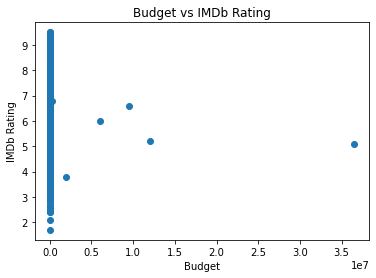

In [19]:
budget = df['budget'].tolist()
rating = df['imdbRating'].tolist()
plt.scatter(budget,rating)
plt.title('Budget vs IMDb Rating')
plt.xlabel('Budget')
plt.ylabel('IMDb Rating')
plt.show()

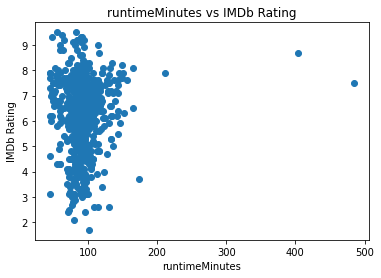

In [20]:
runtimeMinutes = df['runtimeMinutes'].tolist()
rating = df['imdbRating'].tolist()
plt.scatter(runtimeMinutes,rating)
plt.title('runtimeMinutes vs IMDb Rating')
plt.xlabel('runtimeMinutes')
plt.ylabel('IMDb Rating')
plt.show()

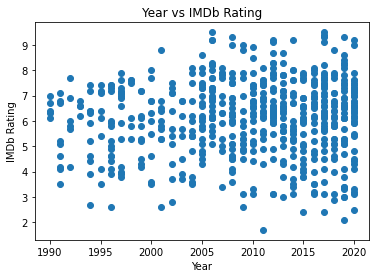

In [21]:
Year = df['Year'].tolist()
rating = df['imdbRating'].tolist()
plt.scatter(Year,rating)
plt.title('Year vs IMDb Rating')
plt.xlabel('Year')
plt.ylabel('IMDb Rating')
plt.show()

The heatmap below shows the correlations between each of my numeric features. None of the correlations are particularly high. 

<AxesSubplot:>

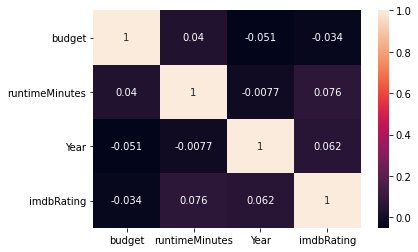

In [22]:
corr_matrix = df[['budget', 'runtimeMinutes', 'Year', 'imdbRating']].corr()
sns.heatmap(corr_matrix, annot=True)

In [23]:
df.groupby('Genre')[['imdbRating']].mean()

,imdbRating
Genre,
Action,4.683333
"Action, Adventure",6.800000
"Action, Adventure, Comedy",5.840000
"Action, Adventure, Drama",5.166667
"Action, Adventure, Drama, Romance, Thriller",NaN
"Action, Adventure, Fantasy",4.300000
"Action, Adventure, Mystery",6.000000
"Action, Adventure, Sci-Fi",5.150000
"Action, Adventure, Sport",7.500000


Each of these can have multiple values that are separated by commas, resulting in these high number of unique combinations. The high number of combinations indicate that there are several combinations that have few movies that are associated with them, which makes it difficult to compare the individual values to IMDb ratings. The correlations of the data for such few movies is unreliable, and combinations of values can affect IMDb ratings differently than the individual values would indicate.

For example, there’s only 1 movie with the genres Action, Adventure, Biography, and Drama, so I wouldn’t expect a new movie with those genres to necessarily have a similar rating. Yet, 2 genres may individually have high IMDb ratings but have low IMDb ratings when combined. These combinations get exponentially more complicated as more features are introduced, like actors that have varying levels of chemistry with other actors and performances in certain genres of movies.

# Data Processing

Used TF-IDF (term frequency-inverse document frequency) to reflect how important each word of each movie plot is.

Used one-hot encoding to be able to perform numeric calculations on the categorical variables.

normalized numeric values so that their distances would be rescaled between 0 to 1

Made a dictionary with each of the cosine similarities for the TF-IDF vectors and one-hot encodings that I previously created

In [2]:
# TF-IDF to reflect how important each word in the movie plot is
tfidf = TfidfVectorizer(stop_words='english')
df = df[df['Plot'].notna()]
tfidf_plot = tfidf.fit_transform(df['Plot'])

# onhot encoding for categorical features
features = ['Genre', 'Actors', 'writers', 'Director', 'Country']
for ft in features:
    df[f'{ft} List'] = df[f'{ft}'].apply(lambda x: x.split(', ') if type(x)==str else [])
    fts = []
    for i in df[f'{ft} List']:
        fts.extend(i)
    fts_no_repeats = [i[0] for i in Counter(fts).most_common()]
    df[f'one-hot {ft}'] = df[f'{ft} List'].apply(lambda x: [int(_ft in x) for _ft in fts_no_repeats])
    

# cosine similarity between tf-idf and one hot to estimate similarity for every pair of movies 
co_sim_dict = {}
attribute_list = ['one-hot Actors','one-hot Director','one-hot Genre','one-hot Country','one-hot writers','Plot'] 
for atr in attribute_list:
    if atr == 'Plot':
        co_sim_dict[atr] = cosine_similarity(tfidf_plot,tfidf_plot)
    else:
        co_sim_dict[atr] = cosine_similarity(df[atr].tolist(),df[atr].tolist())
        
# normalize
def normalize(array):
    norm = np.linalg.norm(array)
    normal_array = array/norm
    return normal_array

df['normalized budget'] = normalize(df['budget'].tolist()) # scale to get the buedge between 0 and 1
df['normalized year'] = normalize(df['Year'].tolist()) # scale to get the buedge between 0 and 1
df['normalized runtimeMinutes'] = normalize(df['runtimeMinutes'].tolist()) # scale to get the buedge between 0 and 1



NameError: name 'TfidfVectorizer' is not defined

In [26]:
ft_list = ['one-hot Actors','one-hot Director','one-hot Genre','one-hot Country','one-hot writers', \
          'normalized budget', 'normalized year', 'normalized runtimeMinutes']
df = df[df['imdbRating'].notna()]
features = df[ft_list]
ratings = df['imdbRating']

In [27]:
featurestore = []
for row in features.iterrows():
    row_ft = []
    for ft_name in ft_list:
        if type(row[1][ft_name]) == list:
            row_ft.extend(row[1][ft_name])
        else:
            row_ft.append(row[1][ft_name])
    featurestore.append(np.array(row_ft))
featurestore = np.array(featurestore)
X_train, X_test, y_train, y_test = train_test_split(featurestore, ratings, test_size=0.3, random_state=42)

# Prediction 

Used kNN Regressor for predictions

In [73]:
# MLP
from sklearn.neighbors import KNeighborsRegressor
regr = KNeighborsRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# df['Predicted Rating'] = y_pred

In [35]:
# mapping to index movies based on title ID or movie name
df = df.reset_index(drop=True)
ID_indices_dict = dict(zip(df['tconst'],df.index))
title_ID_dict = dict(zip(df['Title'],df['tconst']))

# Metrics

Used absolute difference between the ratings to mark the efficiency of the method. The absolute error is between the IMDb rating predicted vs actual in the data. 

The rating differences were overall very low, which indicates good accuracy.

In [74]:
# based on ratings
df['Differences'] = abs(df['imdbRating'] - df['Predicted Rating'])
print('Mean of difference: ', df['Differences'].mean())
print('Standard Deviation of difference: ', df['Differences'].std())
# difference in rating <=1
len(df['Differences']<=1)/len(df)

Mean of difference:  0.7116599138701186
Standard Deviation of difference:  1.3174216248850212


1.0

In [76]:
# based on missing budget
df_with_missing_budgets = df.copy()
df = df[df['budget']!=mean_budget]
print('Mean of difference: ', df['Differences'].mean())
print('Standard Deviation of difference: ', df['Differences'].std())
# difference in rating <=1
len(df['Differences']<=1)/len(df)

Mean of difference:  0.7116599138701186
Standard Deviation of difference:  1.3174216248850212


1.0

# Plots

The IMDb Rating vs Rating Difference scatter plot uses orange dots to represents the rating differences > 3, and blue dots to represent the others. The rating differences are higher for IMDb ratings below 4 because there are much fewer low rated movies in my filtered data.

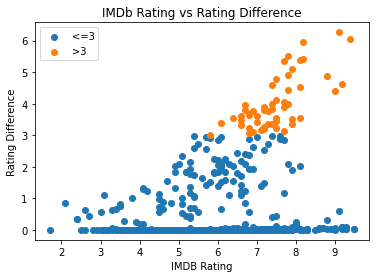

In [79]:
# scatter plot to visualize accuracies of predicted ratings for <=3
rating_lte3 = df[df['Differences']<=3]['imdbRating'].tolist()
diff_lte3 = df[df['Differences']<=3]['Differences'].tolist()
rating_gt3 = df[df['Differences']>3]['imdbRating'].tolist()
diff_gt3 = df[df['Differences']>3]['Differences'].tolist()

plt.scatter(rating_lte3, diff_lte3, label='<=3')
plt.scatter(rating_gt3, diff_gt3, label='>3')
plt.title('IMDb Rating vs Rating Difference')
plt.xlabel('IMDB Rating')
plt.ylabel('Rating Difference')
plt.legend()
plt.show()

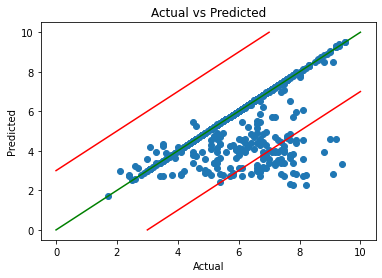

In [80]:
# Actual vs Predicted

rating = df['imdbRating'].tolist()
pred = df['Predicted Rating'].tolist()

plt.scatter(rating, pred)
plt.plot([_ for _ in range(11)], color='g')
plt.plot([_ for _ in range(3, 11)], color='r')
plt.plot([_ for _ in range(3, 11)], [_ for _ in range(8)], color='r')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The below bar charts help visualize the counts of rating differences for different intervals.
This 1st bar chart represents the percentages that I previously mentioned. Again, the vast majority of the rating differences were <= 1. Most of the other rating differences were between 1 and 2. Very few rating differences were higher than 2.

Text(0, 0.5, 'Count')

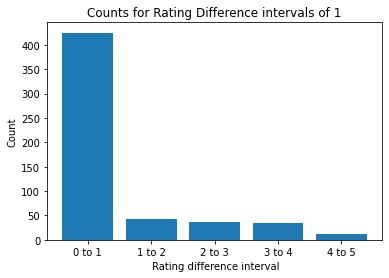

In [82]:
# Prediction difference on intervals of 1
x = ['0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5']
y = [len(df[df['Differences']<=1]), len(df[(df['Differences']>1) & (df['Differences']<=2)]), \
    len(df[(df['Differences']>2) & (df['Differences']<=3)]), \
     len(df[(df['Differences']>3) & (df['Differences']<=4)]), \
     len(df[(df['Differences']>4) & (df['Differences']<=5)])
    ]

plt.bar(x, y)
plt.title('Counts for Rating Difference intervals of 1')
plt.xlabel(' Rating difference interval')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

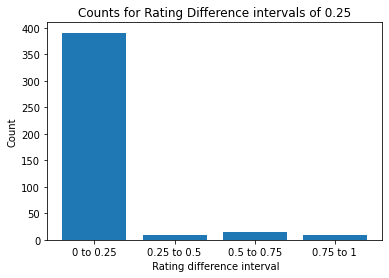

In [84]:
# Prediction difference on intervals of 0.25 for less than 1
x = ['0 to 0.25', '0.25 to 0.5', '0.5 to 0.75', '0.75 to 1']
y = [len(df[df['Differences']<=0.25]), len(df[(df['Differences']>0.25) & (df['Differences']<=0.5)]), \
    len(df[(df['Differences']>0.5) & (df['Differences']<=0.75)]), \
     len(df[(df['Differences']>0.75) & (df['Differences']<=1)]), 
    ]

plt.bar(x, y)
plt.title('Counts for Rating Difference intervals of 0.25')
plt.xlabel(' Rating difference interval')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

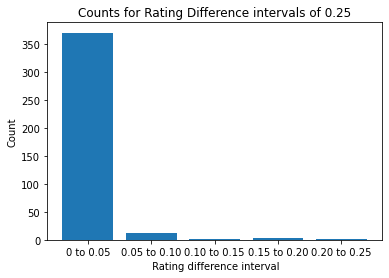

In [87]:
x = ['0 to 0.05', '0.05 to 0.10', '0.10 to 0.15', '0.15 to 0.20', '0.20 to 0.25']
y = [len(df[df['Differences']<=0.05]), len(df[(df['Differences']>0.05) & (df['Differences']<=0.10)]), \
    len(df[(df['Differences']>0.10) & (df['Differences']<=0.15)]), \
     len(df[(df['Differences']>0.15) & (df['Differences']<=0.2)]), 
     len(df[(df['Differences']>0.2) & (df['Differences']<=0.25)]), 
    ]

plt.bar(x, y)
plt.title('Counts for Rating Difference intervals of 0.25')
plt.xlabel(' Rating difference interval')
plt.ylabel('Count')

This Year vs Rating Difference scatter plot shows that the rating differences are about the same regardless of year, including recent years that I initially mentioned had a greater spread of IMDb ratings and would be more similar to the new movies that I would predict ratings for. This indicates that my prediction ratings are accurate for a wide variety of movies.

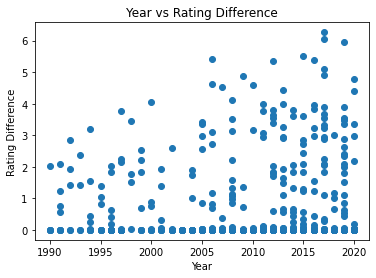

In [88]:
# Consistency in rating difference over years
year = df['Year'].tolist()
diff = df['Differences'].tolist()
plt.scatter(year,diff)
plt.title('Year vs Rating Difference')
plt.xlabel('Year')
plt.ylabel('Rating Difference')
plt.show()